<a href="https://colab.research.google.com/github/dozetype/pytorch-notes/blob/main/cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
# Libraries
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [108]:
train_data = datasets.FashionMNIST(
    root="data", # where downloaded content is
    train=True, # do we want training dataset
    download=True,
    transform=ToTensor(), # How do u wanna transform data
    target_transform=None # How do we wanna the labels/target
)

test_data = datasets.FashionMNIST(
    root="data", # where downloaded content is
    train=False, # do we want training dataset
    download=True,
    transform=ToTensor(), # How do u wanna transform data
    target_transform=None # How do we wanna the labels/target
)
len(train_data), len(test_data)

(60000, 10000)

In [109]:
classes = train_data.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [110]:
image = train_data[0][0]
label = train_data[0][1]
image.shape, classes[label]

(torch.Size([1, 28, 28]), 'Ankle boot')

In [111]:
# classes
train_data.targets[:5]

tensor([9, 0, 0, 3, 0])

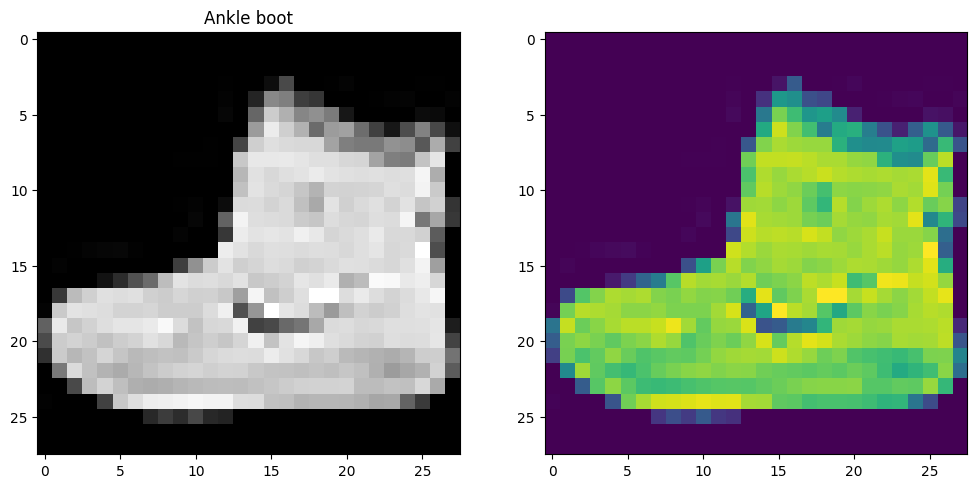

In [112]:
# Viewing image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(classes[label])

plt.subplot(1, 2, 2)
plt.imshow(image.squeeze())

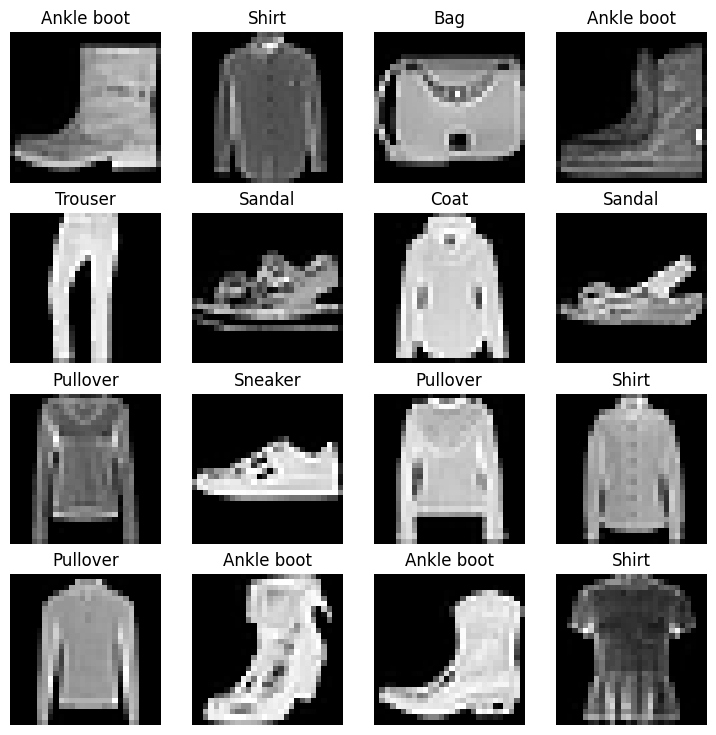

In [113]:
# Plotting more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label])
    plt.axis(False)

In [114]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

# DataLoader
DataLoaders turns dataset into iterable(mini batches)
1. we need to store in mini batches as we can't store all 60000 images in the ram
2. it gives the nn more chance to update the gradient per epoch. update gradient every 32 images instead of 1 time every 60000 img per epoch

In [115]:
# Creating batches
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False) # Better to not shuffle test data
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [116]:
# Extracting a batch from the iterable
train_img_batch, train_label_batch = next(iter(train_dataloader))
train_img_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Label Number: 8


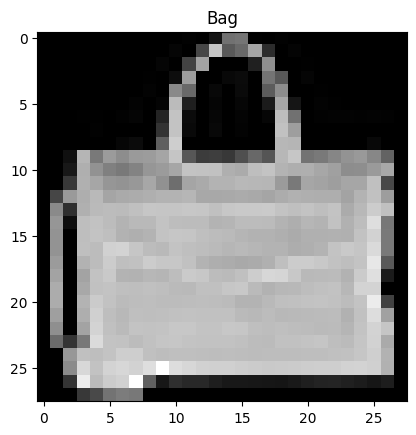

In [117]:
# Show a sample from the batch
# torch.manual_seed(42)
index = torch.randint(0, len(train_img_batch), size=[1]).item() # take a tensor of size (1,) out from 0 to size
img, label = train_img_batch[index], train_label_batch[index]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(classes[label])
print(f"Label Number: {label}")

# Base Line Model
A simple starting point model

In [118]:
# flatten model, similar to nn.Linear
flatten_model = nn.Flatten()

x = train_img_batch[0] # colour_channel, height, width
output = flatten_model(x) # perform forward pass
print(f"Shape before flatten: {x.shape} -> [colour_channel, height, width]")
print(f"Shape after flatten: {output.shape} -> [colour_channel, height*width]")


Shape before flatten: torch.Size([1, 28, 28]) -> [colour_channel, height, width]
Shape after flatten: torch.Size([1, 784]) -> [colour_channel, height*width]


In [119]:
torch.manual_seed(42)
class Model0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)


In [120]:
torch.manual_seed(42)

model0 = Model0(input_shape=784, hidden_units=10, output_shape=len(classes)).to(device)
model0

Model0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [121]:
dummy_data = torch.rand(1, 28, 28).to(device)
model0(dummy_data)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

# Loss fn, Optimizer, Accuracy fn

In [122]:
import requests
from pathlib import Path

if(not Path("helper_functions.py").exists()):
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [123]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [124]:
# Timer

# import time
# start = time.time()

from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

start, end = timer(), timer()
print_train_time(start, end, device)

Train time on cpu: 0.000 seconds


1.399998836859595e-07

In [125]:
def train_step(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        model.train()

        # 1. Forward Pass
        y_pred = model(X)

        # 2. Calculate Loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # 3. Reset gradients, gradient descent, back propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss: .4f} | Train acc: {train_acc: .4f}")

    return {"train_loss": train_loss.item(), "train_acc": train_acc}

In [126]:
def test_step(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, accuracy_fn):
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X) # prediction for the batch
            loss += loss_fn(y_pred, y) # calculate loss for the pred batch with batch of ans
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [127]:
# from tqdm.auto import tqdm

torch.manual_seed(42)
train_start = timer()

epochs = 3

for epochs in range(epochs):
    print(f"Epoch: {epochs}")
    train_step(model=model0, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

    test_step(model=model0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

train_end = timer()
model0_time = print_train_time(train_start, train_end, device)

Epoch: 0
Train loss:  0.5904 | Train acc:  79.1717
Epoch: 1
Train loss:  0.4763 | Train acc:  83.3200
Epoch: 2
Train loss:  0.4550 | Train acc:  84.0517
Train time on cpu: 25.143 seconds


In [128]:
torch.manual_seed(42)

model0_results = test_step(model=model0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model0_results

{'model_name': 'Model0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [129]:
class Model2(nn.Module): # tiny vgg
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print("output shape of block 1: ", x.shape)
        x = self.conv_block_2(x)
        # print("output shape of block 2: ", x.shape)
        x = self.classifier(x)
        # print("output shape of classifier: ", x.shape)
        return x

In [130]:
torch.manual_seed(42)

model2 = Model2(input_shape=1, hidden_units=10, output_shape=len(classes)).to(device)
model2

Model2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# Test from CNN Explainer

In [131]:
# Create a random batch of image
images = torch.rand(32, 3, 64, 64).to(device)
test_image = images[0]
print("Before anything:", test_image.shape)

Before anything: torch.Size([3, 64, 64])


In [132]:
# Create a single conv2D layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding="same").to(device) # kernel 3 and (3,3) is same unless we want non sq kernel
test_image_conv = conv_layer(test_image)
print("After conv2d layer:", test_image_conv.shape)

After conv2d layer: torch.Size([10, 64, 64])


In [133]:
# Create a singel maxpool layer
maxpool_layer = nn.MaxPool2d(kernel_size=2).to(device)
test_image_maxpool = maxpool_layer(test_image_conv)
print("After maxpool layer:", test_image_maxpool.shape)

After maxpool layer: torch.Size([10, 32, 32])


# Going Back to Model2 (CNN)

In [134]:
dummy_image = torch.rand(1, 1, 28, 28).to(device)
model2(dummy_image)

tensor([[ 3.7299e-02, -7.0397e-02,  5.9412e-02, -4.2567e-02, -8.2391e-03,
          1.8364e-02, -2.9954e-07, -1.2342e-02,  2.0266e-02, -9.1326e-05]],
       grad_fn=<AddmmBackward0>)

In [135]:
# Optimizer, loss fn, accuracy fn
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

In [136]:
# Training Loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 3
start_time = timer()

for epochs in range(epochs):
    print(f"Epoch: {epochs}")
    train_step(model=model2, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    test_step(model=model2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

end_time = timer()
model2_time = print_train_time(start_time, end_time, device)

Epoch: 0
Train loss:  0.5865 | Train acc:  78.7417
Epoch: 1
Train loss:  0.3623 | Train acc:  86.8933
Epoch: 2
Train loss:  0.3249 | Train acc:  88.2167
Train time on cpu: 111.760 seconds


In [137]:
# Testing
model2_results = test_step(model=model2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model2_results

{'model_name': 'Model2',
 'model_loss': 0.3212365508079529,
 'model_acc': 88.01916932907348}

# Comparing Results

In [138]:
import pandas as pd
results = pd.DataFrame([model0_results,model2_results])
results

,model_name,model_loss,model_acc
0,Model0,0.476639,83.426518
1,Model2,0.321237,88.019169


In [139]:
results["time"] = [model0_time, model2_time]
results

,model_name,model_loss,model_acc,time
0,Model0,0.476639,83.426518,25.142825
1,Model2,0.321237,88.019169,111.759737


Text(0, 0.5, 'Model')

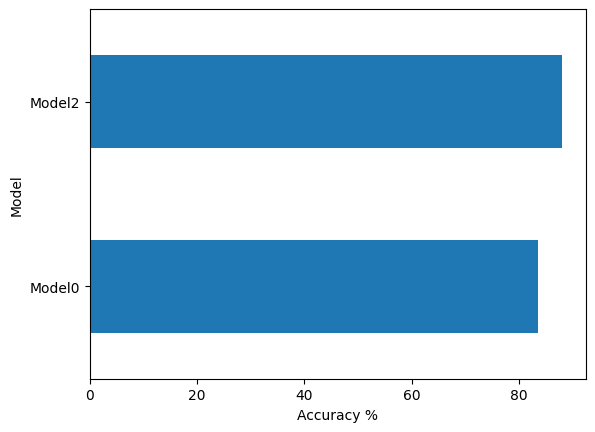

In [140]:
# Visualizing
results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy %")
plt.ylabel("Model")

Text(0, 0.5, 'Model')

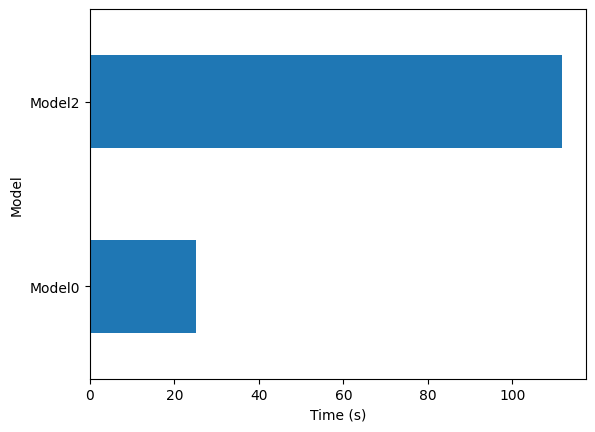

In [141]:
results.set_index("model_name")["time"].plot(kind="barh")
plt.xlabel("Time (s)")
plt.ylabel("Model")

# Evaluating with random images

In [208]:
def make_predictions(model: nn.Module, data: list):
    predictions = []
    model.eval()

    with torch.inference_mode():
        for X in data:
            y_logits = model(X.unsqueeze(dim=0).to(device))
            y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
            predictions.append(y_preds)

    predictions = torch.cat(predictions)
    return predictions

In [199]:
import random

def create_samples():
    images = []
    ans = []
    for img, label in random.sample(list(test_data), k=9):
        images.append(img)
        ans.append(label)
    predictions = make_predictions(model=model2, data=images)
    return images, ans, predictions

In [209]:
def test_samples(images, ans, predictions):
    fig = plt.figure(figsize=(7, 7))
    for i in range(len(images)):
        fig.add_subplot(3, 3, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")

        if ans[i] == predictions[i]:
            color = "green"
        else:
            color = "red"
        plt.title("ans: "+classes[ans[i]]+" | pred: "+classes[predictions[i].item()], fontsize=10, c=color)
        plt.axis(False)

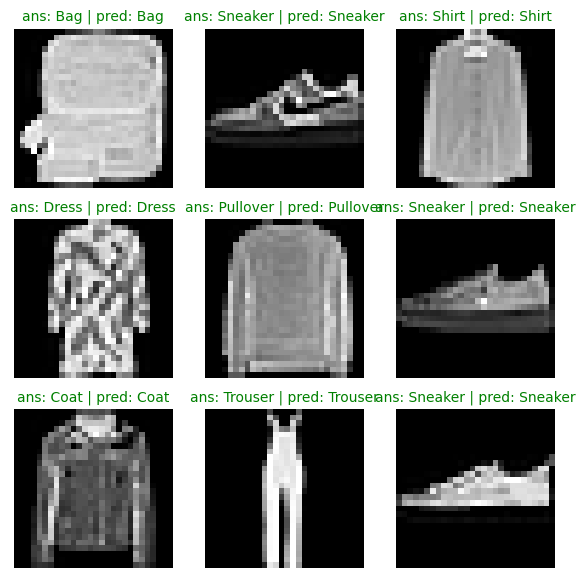

In [210]:
images, ans, predictions = create_samples()
test_samples(images, ans, predictions)